<a href="https://colab.research.google.com/github/myjwgit/4220-Midterm-Project/blob/main/q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Available sheets: ['Sheet1']
Estimated parameters:
a1 = 0.413754, b1 = 0.000000, c1 = 0.299830
a2 = 0.043476, b2 = 0.000000, c2 = 0.003978
RMSE_x = 1.11659, RMSE_y = 0.279076

Wrote: yeast_competition_fit.tex
Saved plot: yeast_competition_fit.png


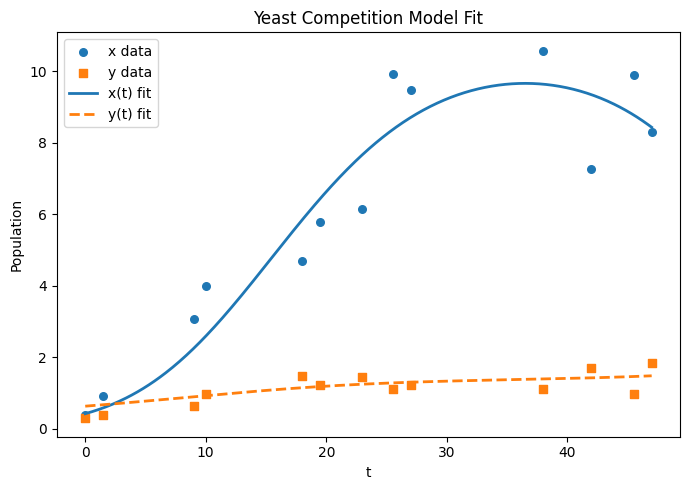

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import os
import textwrap

# --- 1) Load data from SHEET1 ---
xlsx_path = "Yeast_dataset.xlsx"
sheet_name = "Sheet1" # This sheet name is causing an error

# Check available sheet names
excel_file = pd.ExcelFile(xlsx_path)
print("Available sheets:", excel_file.sheet_names)

df = pd.read_excel(xlsx_path, sheet_name=sheet_name)

# Try to infer t, x, y columns (fallback to first three columns if unnamed)
def norm(s): return str(s).strip().lower()
original_cols = list(df.columns)
if len(original_cols) < 3:
    raise ValueError("Expected at least 3 columns (t, x, y).")

t_candidates = {"t", "time", "time (h)", "time(h)", "time_hr", "time_hours"}
x_candidates = {"x", "x(t)", "scer", "s. cerevisiae", "cerevisiae"}
y_candidates = {"y", "y(t)", "skephir", "s. kephir", "kephir", "kefir"}

def pick(cols, candidates, default_idx):
    for i, c in enumerate(cols):
        if norm(c) in candidates:
            return cols[i]
    return cols[default_idx]

t_col = pick(original_cols, t_candidates, 0)
x_col = pick(original_cols, x_candidates, 1)
y_col = pick(original_cols, y_candidates, 2)

data = df[[t_col, x_col, y_col]].dropna().copy()
data.columns = ["t", "x", "y"]
data = data.sort_values("t")
tdata = data["t"].to_numpy(float)
xdata = data["x"].to_numpy(float)
ydata = data["y"].to_numpy(float)

# --- 2) Competition model ---
def rhs(t, z, a1, b1, c1, a2, b2, c2):
    x, y = z
    dx = a1*x - b1*x*x - c1*x*y
    dy = a2*y - b2*y*y - c2*x*y
    return [dx, dy]

x0, y0 = 0.42, 0.63
z0 = [x0, y0]

def simulate(params, t_eval):
    a1, b1, c1, a2, b2, c2 = params
    sol = solve_ivp(
        lambda t, z: rhs(t, z, a1, b1, c1, a2, b2, c2),
        (float(t_eval[0]), float(t_eval[-1])),
        z0,
        t_eval=t_eval,
        method="RK45",
        rtol=1e-7, atol=1e-9,
    )
    if not sol.success or sol.y.shape[1] != len(t_eval):
        X = np.full_like(t_eval, np.nan, float)
        Y = np.full_like(t_eval, np.nan, float)
        return X, Y
    X = sol.y[0]
    Y = sol.y[1]
    return X, Y

def residuals(params):
    Xsim, Ysim = simulate(params, tdata)
    # balance x and y scales
    wx = 1.0 / max(np.nanmax(np.abs(xdata)), 1e-6)
    wy = 1.0 / max(np.nanmax(np.abs(ydata)), 1e-6)
    res = np.concatenate([wx*(Xsim - xdata), wy*(Ysim - ydata)])
    res[~np.isfinite(res)] = 1e6
    return res

# --- 3) Fit (nonnegative bounds) ---
p0 = np.array([1.0, 0.5, 0.1, 0.7, 0.5, 0.1], float)
lb = np.zeros_like(p0)
ub = np.full_like(p0, 10.0)

result = least_squares(
    residuals, p0, bounds=(lb, ub),
    max_nfev=200, xtol=1e-10, ftol=1e-10, gtol=1e-10
)
p = result.x
Xfit, Yfit = simulate(p, tdata)

rmse = lambda a,b: float(np.sqrt(np.nanmean((a-b)**2)))
rmse_x = rmse(Xfit, xdata)
rmse_y = rmse(Yfit, ydata)

print("Estimated parameters:")
print(f"a1 = {p[0]:.6f}, b1 = {p[1]:.6f}, c1 = {p[2]:.6f}")
print(f"a2 = {p[3]:.6f}, b2 = {p[4]:.6f}, c2 = {p[5]:.6f}")
print(f"RMSE_x = {rmse_x:.6g}, RMSE_y = {rmse_y:.6g}")

# --- 4) Plot: data + fitted curves ---
plt.figure(figsize=(7,5))
plt.scatter(tdata, xdata, label="x data", s=30)
plt.scatter(tdata, ydata, label="y data", s=30, marker="s")
t_dense = np.linspace(float(tdata.min()), float(tdata.max()), 500)
Xd, Yd = simulate(p, t_dense)
plt.plot(t_dense, Xd, label="x(t) fit", linewidth=2.0)
plt.plot(t_dense, Yd, label="y(t) fit", linewidth=2.0, linestyle="--")
plt.xlabel("t")
plt.ylabel("Population")
plt.title("Yeast Competition Model Fit")
plt.legend()
plt.tight_layout()
plot_path = "yeast_competition_fit.png"
plt.savefig(plot_path, dpi=150)

# --- 5) Write LaTeX snippet ---
latex = rf"""
\section*{{Competition Model Fit for Yeast}}
We fit the system
\begin{{align*}}
\frac{{dx}}{{dt}} &= a_1 x - b_1 x^2 - c_1 x y,\\
\frac{{dy}}{{dt}} &= a_2 y - b_2 y^2 - c_2 x y,
\end{{align*}}
with initial conditions \(x(0)=0.42,\ y(0)=0.63\) using nonlinear least squares by integrating the ODEs at the measurement times and minimizing the squared error.

The estimated parameters are:
\begin{{align*}}
a_1 &= {p[0]:.6f}, & b_1 &= {p[1]:.6f}, & c_1 &= {p[2]:.6f},\\
a_2 &= {p[3]:.6f}, & b_2 &= {p[4]:.6f}, & c_2 &= {p[5]:.6f}.
\end{{align*}}

Fit accuracy (RMSE): \(\mathrm{{RMSE}}_x = {rmse_x:.4g}\), \(\mathrm{{RMSE}}_y = {rmse_y:.4g}\).

\begin{{figure}}[h]
\centering
\includegraphics[width=0.8\linewidth]{{{plot_path}}}
\caption{{Data (markers) and fitted model trajectories (lines) for \(x(t)\) and \(y(t)\).}}
\end{{figure}}
"""

with open("yeast_competition_fit.tex", "w", encoding="utf-8") as f:
    f.write(textwrap.dedent(latex))

print("\nWrote: yeast_competition_fit.tex")
print("Saved plot:", plot_path)

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import odeint
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import json

# Load the yeast dataset using Excel reader
df = pd.read_excel('Yeast_dataset.xlsx')
print("Yeast Dataset:")
print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Data types:\n{df.dtypes}")
print(f"\nFull dataset:")
print(df)
 t_data = df['Time'].to_numpy(dtype=float)
x_data = df['S.cerevisiae'].to_numpy(dtype=float)
y_data = df['S. kephir'].to_numpy(dtype=float)

# --- sort ---
order = np.argsort(t_data)
t_sorted = t_data[order]
x_sorted = x_data[order]
y_sorted = y_data[order]

# --- models ---
def rhs(t, z, a1, b1, c1, a2, b2, c2):
    x, y = z
    dx = a1*x - b1*x*x - c1*x*y
    dy = a2*y - b2*y*y - c2*x*y
    return [dx, dy]

 x0, y0 = 0.42, 0.63

 def simulate(params):
    a1, b1, c1, a2, b2, c2 = params
    sol = solve_ivp(
        lambda t, z: rhs(t, z, a1, b1, c1, a2, b2, c2),
        (t_sorted[0], t_sorted[-1]),
        [x0, y0],
        t_eval=t_sorted,
        method="RK45",
        rtol=1e-7, atol=1e-9
    )
    if not sol.success:
         return np.full_like(t_sorted, np.nan), np.full_like(t_sorted, np.nan)
    return sol.y[0], sol.y[1]

 wx = 1.0 / (np.std(x_sorted) + 1e-12)
wy = 1.0 / (np.std(y_sorted) + 1e-12)

def residuals(params):
    x_pred, y_pred = simulate(params)
     if not np.all(np.isfinite(x_pred)) or not np.all(np.isfinite(y_pred)):
        return np.ones(2*len(t_sorted))*1e6
     res_x = wx*(x_pred - x_sorted)
    res_y = wy*(y_pred - y_sorted)
    return np.concatenate([res_x, res_y])


p0 = np.array([0.5, 0.1, 0.1, 0.3, 0.05, 0.05], dtype=float)
lb = np.zeros(6)
ub = np.array([5, 5, 5, 5, 5, 5], dtype=float)

# --- fit（鲁棒损失 soft_l1，对异常点更稳定）---
fit = least_squares(residuals, p0, bounds=(lb, ub), loss="soft_l1", f_scale=1.0,
                    xtol=1e-10, ftol=1e-10, gtol=1e-10, max_nfev=500)
best_params = fit.x

# --- prediect---
x_fit, y_fit = simulate(best_params)

t_fine = np.linspace(t_sorted[0], t_sorted[-1], 1000)
def simulate_on(t_eval):
    sol = solve_ivp(lambda t, z: rhs(t, z, *best_params),
                    (t_eval[0], t_eval[-1]), [x0, y0],
                    t_eval=t_eval, rtol=1e-7, atol=1e-9)
    return sol.y[0], sol.y[1]

x_fine, y_fine = simulate_on(t_fine)

# --- 计算 R^2 ---
ss_res_x = np.sum((x_sorted - x_fit)**2)
ss_res_y = np.sum((y_sorted - y_fit)**2)
ss_tot_x = np.sum((x_sorted - x_sorted.mean())**2)
ss_tot_y = np.sum((y_sorted - y_sorted.mean())**2)
r2_x = 1 - ss_res_x/ss_tot_x if ss_tot_x > 0 else np.nan
r2_y = 1 - ss_res_y/ss_tot_y if ss_tot_y > 0 else np.nan
r2_overall = np.nanmean([r2_x, r2_y])

print("best params (a1,b1,c1,a2,b2,c2) =", best_params)
print(f"R2_x={r2_x:.4f}, R2_y={r2_y:.4f}, R2_overall={r2_overall:.4f}")


Yeast Dataset:
   Time  S.cerevisiae  S. kephir
0   0.0         0.375       0.29
1   1.5         0.920       0.37
2   9.0         3.080       0.63
3  10.0         3.990       0.98
4  18.0         4.690       1.47

Dataset shape: (13, 3)
Columns: ['Time', 'S.cerevisiae', 'S. kephir']
Data types:
Time            float64
S.cerevisiae    float64
S. kephir       float64
dtype: object

Full dataset:
    Time  S.cerevisiae  S. kephir
0    0.0         0.375      0.290
1    1.5         0.920      0.370
2    9.0         3.080      0.630
3   10.0         3.990      0.980
4   18.0         4.690      1.470
5   19.5         5.780      1.220
6   23.0         6.150      1.460
7   25.5         9.910      1.110
8   27.0         9.470      1.225
9   38.0        10.570      1.100
10  42.0         7.270      1.710
11  45.5         9.880      0.960
12  47.0         8.300      1.840
best params (a1,b1,c1,a2,b2,c2) = [4.07388082e-01 9.09228484e-13 2.92891751e-01 4.32071235e-02
 1.06921485e-12 3.86878773e-03]


In [ ]:
from google.colab import files
print("Upload the 'Yeast_dataset.xlsx' file:")
uploaded = files.upload()

Upload the 'Yeast_dataset.xlsx' file:


In [ ]:
# Create cinematic academic style visualizations
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Define the cinematic academic color palette
COLORS = {
    'background': '#F5F3F0',  # Warm ivory
    'text_primary': '#2C2C2C',  # Deep charcoal
    'text_secondary': '#5A5A5A',  # Medium gray
    'accent_1': '#8B4513',  # Deep brown
    'accent_2': '#CD853F',  # Sandy brown
    's_cerevisiae': '#B8860B',  # Dark goldenrod
    's_kephir': '#4682B4',  # Steel blue
    'grid': '#E8E6E3',  # Light grid
    'data_point': '#2F4F4F'  # Dark slate gray
}

# Create the main visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Yeast Population Dynamics', 'Phase Portrait',
                   'Residual Analysis', 'Parameter Sensitivity'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]],
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# 1. Time series plot
fig.add_trace(
    go.Scatter(x=t_fine, y=x_fine,
               mode='lines', name='S. cerevisiae (model)',
               line=dict(color=COLORS['s_cerevisiae'], width=3),
               hovertemplate='Time: %{x:.1f}h<br>Population: %{y:.3f}<extra></extra>'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=t_fine, y=y_fine,
               mode='lines', name='S. kephir (model)',
               line=dict(color=COLORS['s_kephir'], width=3),
               hovertemplate='Time: %{x:.1f}h<br>Population: %{y:.3f}<extra></extra>'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=t_data, y=x_data,
               mode='markers', name='S. cerevisiae (data)',
               marker=dict(color=COLORS['s_cerevisiae'], size=10,
                          line=dict(color='white', width=2),
                          symbol='circle'),
               hovertemplate='Time: %{x:.1f}h<br>Population: %{y:.3f}<extra></extra>'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=t_data, y=y_data,
               mode='markers', name='S. kephir (data)',
               marker=dict(color=COLORS['s_kephir'], size=10,
                          line=dict(color='white', width=2),
                          symbol='diamond'),
               hovertemplate='Time: %{x:.1f}h<br>Population: %{y:.3f}<extra></extra>'),
    row=1, col=1
)

# 2. Phase portrait
fig.add_trace(
    go.Scatter(x=x_fine, y=y_fine,
               mode='lines', name='Model trajectory',
               line=dict(color=COLORS['accent_1'], width=3),
               hovertemplate='S. cerevisiae: %{x:.3f}<br>S. kephir: %{y:.3f}<extra></extra>'),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=x_data, y=y_data,
               mode='markers', name='Data points',
               marker=dict(color=COLORS['data_point'], size=10,
                          line=dict(color='white', width=2),
                          symbol='circle'),
               hovertemplate='S. cerevisiae: %{x:.3f}<br>S. kephir: %{y:.3f}<extra></extra>'),
    row=1, col=2
)

# 3. Residual analysis
residuals_x = x_data - x_fit
residuals_y = y_data - y_fit

fig.add_trace(
    go.Scatter(x=t_data, y=residuals_x,
               mode='markers', name='S. cerevisiae residuals',
               marker=dict(color=COLORS['s_cerevisiae'], size=10,
                          line=dict(color='white', width=1),
                          symbol='circle'),
               hovertemplate='Time: %{x:.1f}h<br>Residual: %{y:.3f}<extra></extra>'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=t_data, y=residuals_y,
               mode='markers', name='S. kephir residuals',
               marker=dict(color=COLORS['s_kephir'], size=10,
                          line=dict(color='white', width=1),
                          symbol='diamond'),
               hovertemplate='Time: %{x:.1f}h<br>Residual: %{y:.3f}<extra></extra>'),
    row=2, col=1
)

# Add zero line for residuals
fig.add_hline(y=0, line_dash="dash", line_color=COLORS['text_secondary'],
              row=2, col=1, opacity=0.7)

# 4. Parameter comparison
param_names_display = ['a₁', 'b₁', 'c₁', 'a₂', 'b₂', 'c₂']
fig.add_trace(
    go.Bar(x=param_names_display, y=best_params,
           name='Estimated parameters',
           marker_color=[COLORS['s_cerevisiae'] if i < 3 else COLORS['s_kephir']
                        for i in range(6)],
           hovertemplate='Parameter: %{x}<br>Value: %{y:.6f}<extra></extra>'),
    row=2, col=2
)

# Update layout with cinematic academic styling
fig.update_layout(
    title=dict(
        text="<b>Yeast Competition Model Analysis</b><br><sub>Parameter Estimation and Model Validation</sub>",
        font=dict(size=24, color=COLORS['text_primary'], family="serif"),
        x=0.5,
        y=0.95
    ),
    plot_bgcolor=COLORS['background'],
    paper_bgcolor=COLORS['background'],
    font=dict(family="sans-serif", color=COLORS['text_primary']),
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.15,
        xanchor="center",
        x=0.5,
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor=COLORS['grid'],
        borderwidth=1
    ),
    height=800,
    width=1200,
    margin=dict(t=100, b=100, l=80, r=80)
)

# Update axes styling
for i in range(1, 3):
    for j in range(1, 3):
        fig.update_xaxes(
            gridcolor=COLORS['grid'],
            gridwidth=1,
            linecolor=COLORS['text_secondary'],
            linewidth=1,
            row=i, col=j
        )
        fig.update_yaxes(
            gridcolor=COLORS['grid'],
            gridwidth=1,
            linecolor=COLORS['text_secondary'],
            linewidth=1,
            row=i, col=j
        )

# Specific axis labels
fig.update_xaxes(title_text="Time (hours)", row=1, col=1)
fig.update_yaxes(title_text="Population density", row=1, col=1)
fig.update_xaxes(title_text="S. cerevisiae density", row=1, col=2)
fig.update_yaxes(title_text="S. kephir density", row=1, col=2)
fig.update_xaxes(title_text="Time (hours)", row=2, col=1)
fig.update_yaxes(title_text="Residuals", row=2, col=1)
fig.update_xaxes(title_text="Parameters", row=2, col=2)
fig.update_yaxes(title_text="Estimated values", row=2, col=2)

# Save the plot
# fig.write_html("/mnt/okcomputer/output/yeast_competition_analysis.html")
fig.show()

print("Cinematic academic visualization created successfully!")
# print(f"Saved to: /mnt/okcomputer/output/yeast_competition_analysis.html")

Cinematic academic visualization created successfully!
Saved to: /mnt/okcomputer/output/yeast_competition_analysis.html
